# Phase Diagram in 3D

## 1. Setup

In [7]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

t = 1
d = 3

N = 1000

# np.where(if statement, if true, if false)
def I_1(x):
    return np.where(np.abs(x) < (2 * t),
             np.heaviside(x + 2*t, 1) - (1 / np.pi) * np.arccos(np.clip(x / (2*t), -1, 1)),
             np.heaviside(x + 2*t, 1))

def I_1_scipy(x):
    if np.abs(x) < 2*t:
        result = np.heaviside(x + 2*t, 1) - (1 / np.pi) * np.arccos(x / (2*t))
    else:
        result = np.heaviside(x + 2*t, 1)
    return result

k1_array = np.linspace(-np.pi, np.pi, N)
k2_array = np.linspace(-np.pi, np.pi, N)
k1k1, k2k2 = np.meshgrid(k1_array, k2_array)

def I_3(x):
    shifted_I_1 = x + 2 * t * (np.cos(k1k1) + np.cos(k2k2))
    func_val_grid = I_1(shifted_I_1)

    intermediate = np.trapz(func_val_grid, k2_array, axis=1)
    result = np.trapz(intermediate, k1_array)

    return result / ((2 * np.pi)**2)

def I_3_scipy(x):
    I_1_shifted = lambda k1, k2: I_1_scipy(x + 2 * t * (np.cos(k1) + np.cos(k2)))

    integral_val = integrate.dblquad(I_1_shifted, -np.pi, np.pi, -np.pi, np.pi, epsabs=1e-4)

    return_val = integral_val[0] / ((2 * np.pi)**2)

    return return_val

def rho_3d(mu, U):
    if U >= 0:
        return I_3(mu) + I_3(mu - U)
    elif U < 0:
        return 2 * I_3(mu - U/2)

def find_mu_of_rho(rho, U):
    bracket = (-2*t*d, U + 2*t*d) # minimal and maximal values of mu
    func_mu = lambda mu: rho_3d(mu, U) - rho
    result = root_scalar(func_mu, bracket=bracket, method='brentq', xtol=1e-4)

    if result.converged:
        return result.root
    else:
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")

def create_mu_list(rho_array, U):
    mu_values = []
    for rho_i in rho_array:
        print(f'\rProgress: {(rho_i/2 * 100):.1f}%{' ' * 20}', end="", flush=True)
        try:
            mu = find_mu_of_rho(rho_i, U)
            mu_values.append(mu)
        except RuntimeError:
            mu_values.append(np.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")
    return mu_values

def one_plot(x_array, y_array,x_label, y_label, title):
    plt.figure(dpi=100)
    # Plot erstellen
    plt.plot(x_array, y_array, linestyle='-')
    
    # Achsenbeschriftungen und Titel
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show() 

In [10]:
print(I_3(1))

0.6428352805145817


In [11]:
print(I_3_scipy(1))

0.6428349268259388


### Testing Setup

Progress: 99.7%                    

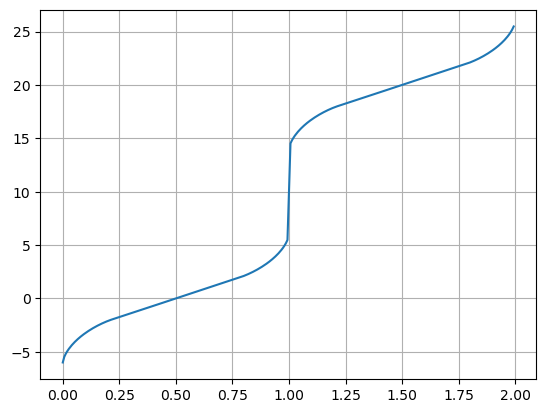

In [28]:
rho_values = np.linspace(0, 2, 300, endpoint=False)

mu_values = create_mu_list(rho_values, 20)

one_plot(rho_values, mu_values, '','','')

## 2. Find $U_c(\rho)$

### Setup

In [29]:
def find_U_c_of_rho(rho):
    if rho <= 1:
        func_U = lambda U: find_mu_of_rho(rho, U) + 2*t*d - U
        result = root_scalar(func_U, bracket=(0, 4*t*d), method='brentq', xtol=1e-3)
    elif rho > 1:
        func_U = lambda U: find_mu_of_rho(rho, U) - 2*t*d
        result = root_scalar(func_U, bracket=(0, 4*t*d), method='brentq', xtol=1e-3)

    if result.converged:
        return result.root
    else:
        print(result.flag)
        raise RuntimeError(f"Keine Nullstelle gefunden für rho={rho}")
    
def create_U_c_array(rho_array):
    U_c_list = []

    for rho_i in rho_array:
        print(f'\rProgress: {(rho_i/2 * 100):.1f}%{' ' * 20}', end="", flush=True)
        try:
            U_i = find_U_c_of_rho(rho_i)
            U_c_list.append(U_i)
        except RuntimeError:
            U_c_list.append(np.nan)
            print(f"Keine Nullstelle gefunden für rho={rho_i}")

    U_c_array = np.array(U_c_list)

    return U_c_array

### Calculation

In [31]:
rho_values = np.linspace(0, 2, 600, endpoint=True)
U_c_array = create_U_c_array(rho_values)

Progress: 100.0%                    

### Plots

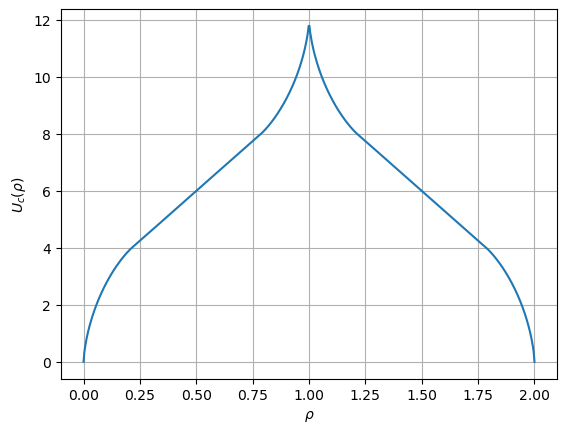

In [32]:
one_plot(rho_values, U_c_array, r'$\rho$', r'$U_c(\rho)$', '')
U_c_array_normalized = U_c_array / (np.max(U_c_array))

In [2]:
from matplotlib.ticker import MultipleLocator

def phase_diagram(x_values, y_values, x_label, y_label, y_max, title='none', legend=False, fill=True, alph=1):    
    # Create the plot
    fig, ax = plt.subplots()
    
    # Plot the dividing curve
    ax.plot(x_values, y_values, label=r'$U_c$', color='black')
    
    # Plot the vertical line at x = 1, starting from y=1 upwards
    ax.vlines(x=1, ymin=1, ymax=y_max, color='black', linestyle='-', label='MIT')
    
    # Fill areas for visualization (optional)
    if fill:
        ax.fill_between(x_values, y_values, y_max, where=(x_values < 1), 
                        interpolate=True, color='#DF1728', alpha=alph, label='Area 1')
        
        ax.fill_between(x_values, y_values, y_max, where=(x_values > 1), 
                        interpolate=True, color='#4E3DE1', alpha=alph, label='Area 2')
        
        ax.fill_between(x_values, 0, y_values, color='#B11CC2',
                         alpha=alph, label='Area 3 (Above Curve)')
    
    ax.plot(1, 1, marker='o', color='black', markersize=6, label='QCP')
    
    #ax.text(1, 0.7, 'QCP', fontsize=12, color='black', ha='center')
    ax.text(0.25, 1.3, 'Only singly \noccupied states', fontsize=12, color='black', ha='left')
    ax.text(1.25, 1.3, 'All states occupied\nNo holes', fontsize=12, color='black', ha='left')
    ax.text(1, 0.4, 'Holes, singly and\n doubly occupied states', fontsize=12, color='black', ha='center')
    ax.text(0.48, 0.52, r'$U_c$', fontsize=12, color='black', ha='right')
    ax.text(1.52, 0.52, r'$\overline{U}_c$', fontsize=12, color='black', ha='left')
    
    # Labels and legend
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title != 'none':
        ax.set_title(title)
    if legend == True:
        ax.legend()
    ax.set_xlim(0, 2)
    ax.set_ylim(0, y_max)
    ax.tick_params(top=True, right=True, direction='in', pad=7)
    # Set major tick intervals
    ax.xaxis.set_major_locator(MultipleLocator(0.25))  # x-axis ticks every 0.2 units
    ax.yaxis.set_major_locator(MultipleLocator(0.2))  # y-axis ticks every 0.5 units

    plt.show()

#phase_diagram(rho_values, U_c_array_normalized, r'$\rho$', r'$U_c(\rho) / W$', 1.6, fill=False)

### Saving

In [3]:
print('[')
for U_val in U_c_array:
    print(f'{U_val},')
print(']')

[


NameError: name 'U_c_array' is not defined

In [8]:
rho_values = np.linspace(0, 2, 600, endpoint=True)
U_c_array_copy = [
0.0,
0.33372573740146977,
0.5243903807870587,
0.6813442086200466,
0.8191398353241509,
0.9438860558076985,
1.0588692773838322,
1.1661818430362392,
1.2671474893239998,
1.3628017770963567,
1.4538742165124754,
1.540921814958816,
1.6244043382378772,
1.7046883901542647,
1.7820829254129604,
1.8568342167148617,
1.9291694033644755,
1.9992858033055887,
2.067306337828225,
2.1333846281485247,
2.1976583709314794,
2.2602217684472774,
2.321172800877164,
2.3806243400694513,
2.438618823284725,
2.4952588420408057,
2.550581030309679,
2.6046781200324185,
2.6575570812959097,
2.7093193091974066,
2.759971779060244,
2.809563684830296,
2.858148674228832,
2.905758858054105,
2.9524187913025144,
2.9981600761261986,
3.043010295155451,
3.0870008340622497,
3.1301533698574118,
3.1725015738465316,
3.214045478079897,
3.2548273603980005,
3.294846379620159,
3.334124112887813,
3.3726834405720463,
3.4105340724052895,
3.4476954031050817,
3.4841735833038694,
3.519978080378271,
3.555126611985714,
3.5896060868612287,
3.623443788026031,
3.656649844182906,
3.689206237083087,
3.7211305311549623,
3.7524290731545054,
3.7831322110328203,
3.8131487963306463,
3.8425225882534897,
3.871204280479954,
3.8992009314199234,
3.9264699783877752,
3.952946302922707,
3.9785035981364,
4.002744497224849,
4.025326886805186,
4.0483985924416,
4.071511906453178,
4.0946309247761326,
4.117760452436413,
4.140905061382142,
4.164012697003056,
4.187152582896655,
4.210297681549609,
4.2334509313377415,
4.256609955491781,
4.279774412409907,
4.302944124460576,
4.326083224419305,
4.3492645058961115,
4.372454874494843,
4.395649786976568,
4.418847553602912,
4.442049802952827,
4.465258774488988,
4.488474219051829,
4.511738873306845,
4.534966302533558,
4.558199435933062,
4.581438019221871,
4.604677139593354,
4.627923801782483,
4.651175269933475,
4.674430290385884,
4.697695611781656,
4.720963793558935,
4.744236517344065,
4.767519761759524,
4.790802577482065,
4.814089217069819,
4.837382514876135,
4.860678586960895,
4.883974798433916,
4.907279663964591,
4.930591624129851,
4.953905089805142,
4.977233487107487,
5.00056293003338,
5.023846116248327,
5.047176094568018,
5.07051302983152,
5.093850301609518,
5.117191594769012,
5.140537690760129,
5.163884085388706,
5.187232954441738,
5.21058223663106,
5.233935645901479,
5.257291961494248,
5.280653729119617,
5.304007342576898,
5.3273796726335485,
5.350745977755651,
5.374110610865528,
5.3974853106825345,
5.420859340329104,
5.44423277295972,
5.467610525075684,
5.490989111207528,
5.514370767269567,
5.537754320413743,
5.5611440563532915,
5.584536242754204,
5.607884493067232,
5.6312794327227795,
5.654672943191093,
5.678068174220975,
5.701462110113718,
5.724852529860043,
5.748248477523006,
5.7716444103789115,
5.795045680624035,
5.818441323652444,
5.841840020622495,
5.865239193243894,
5.888635743909348,
5.912034901180473,
5.93543070748522,
5.958833202178164,
5.982237090890012,
6.0056374601862395,
6.029036855059779,
6.052436937975875,
6.0758287384207526,
6.099231156444587,
6.122632011611439,
6.146035495690807,
6.169432440657998,
6.192827565170781,
6.216225430909109,
6.2396175451751965,
6.263011811591547,
6.286405834644987,
6.30980215614733,
6.333696965469519,
6.3570876827538525,
6.380477011932303,
6.40386634244004,
6.427253113455582,
6.45063511916612,
6.474019011419154,
6.4974029284756165,
6.5202810528807325,
6.544162836195572,
6.567541549593424,
6.590917460455493,
6.614290913906403,
6.6371574751848845,
6.661024334837181,
6.684387727068468,
6.707748579593819,
6.731107670278825,
6.754463026624183,
6.777814719835732,
6.8011663456308815,
6.824510595429358,
6.84785440435081,
6.8711984907367905,
6.894533108428592,
6.917870314238629,
6.941201184272994,
6.964527512465611,
6.987895200946112,
7.011216476885404,
7.0345374730146935,
7.057852452094732,
7.081163650787997,
7.104463345938135,
7.127764561691492,
7.151063792893553,
7.174330623423619,
7.197617206668051,
7.220905524214403,
7.244190648137415,
7.267463636803552,
7.290739669952811,
7.31400113630095,
7.3372639698656,
7.360518581192579,
7.3837699440525455,
7.40701455509034,
7.430264002848591,
7.453498738704214,
7.476724499155048,
7.499951009243907,
7.52317047306619,
7.546381476510125,
7.569585839969671,
7.592788909745394,
7.615989937211392,
7.639179052824072,
7.662355297892068,
7.685533119504601,
7.7086991771664195,
7.731862581343721,
7.755023554898035,
7.778175272077156,
7.801318681592847,
7.824452052784454,
7.8475775612822245,
7.870696590340764,
7.893814707331235,
7.916930849843525,
7.940015805534664,
7.963118742744596,
7.986208945989515,
8.009596274101668,
8.034550809670197,
8.060534172127772,
8.087392536745787,
8.11497572811671,
8.143261220313821,
8.172218880930078,
8.201888568993887,
8.232178585090567,
8.263170532589555,
8.294756664870707,
8.327007420203707,
8.359882187146454,
8.393403532461956,
8.42755432635075,
8.462402938088715,
8.49785085449233,
8.533987884038003,
8.570801169966634,
8.608309971531689,
8.646518155589897,
8.685447327339057,
8.72510292622301,
8.765497071418,
8.806663236419732,
8.84861401888108,
8.89134920130262,
8.934892529742333,
8.979320953026008,
9.024617325162628,
9.070818026959465,
9.117949056631478,
9.16603465071716,
9.215126129870933,
9.265251918288273,
9.316445802810346,
9.368768300286725,
9.422246433187816,
9.47695251006106,
9.532930273001869,
9.590242031514485,
9.648950679112549,
9.709130905760281,
9.770890511214356,
9.83429054716574,
9.899454016730733,
9.966494459827263,
10.035536225475584,
10.106723375432281,
10.180252074528793,
10.256296766153067,
10.33509983242388,
10.416948429005414,
10.50217126571741,
10.591112275104924,
10.684398080367096,
10.782616844642595,
10.886611176968266,
10.99755339221584,
11.117110783035843,
11.247847281577945,
11.394152163195782,
11.56505604287743,
11.788442672955629,
11.788432752289149,
11.565056441808167,
11.394158079811604,
11.247834700869348,
11.117105468691454,
10.997545642109777,
10.88659890817669,
10.782613948761563,
10.684403505552842,
10.5911652656103,
10.502126056628622,
10.41694208943126,
10.335104731764844,
10.256294405914897,
10.180246602317993,
10.106726918400987,
10.03553977841258,
9.966484056276947,
9.899457941657593,
9.834293253323175,
9.770897162097771,
9.709139567318898,
9.648951229811736,
9.5902311039406,
9.53292655737615,
9.47694882764329,
9.422246529102853,
9.368770033019109,
9.316445992499963,
9.265244591444384,
9.215130936197204,
9.166042356210955,
9.117948371318967,
9.070818148318507,
9.024615199930949,
8.979319066364855,
8.934893552932886,
8.891308997959166,
8.848613364681494,
8.806659399553848,
8.76549584341678,
8.725098299900269,
8.68544727003574,
8.646523001485402,
8.608308560097166,
8.570803770102916,
8.533985212936068,
8.497849626208241,
8.462358117357422,
8.4275519852572,
8.393402583792321,
8.359877681351696,
8.32700737016491,
8.29475614092117,
8.263168443417245,
8.23217631558056,
8.201887482752479,
8.172265969960996,
8.143262453991897,
8.11497556671137,
8.08739295821416,
8.060534984943414,
8.03455093350703,
8.009596261293186,
7.986209271500028,
7.963119268126733,
7.940015216016488,
7.916930250319499,
7.893812848523762,
7.870697818497288,
7.847578473855774,
7.824450958730948,
7.801318642720147,
7.778178291304993,
7.755025121109589,
7.731861733777172,
7.708700545427502,
7.685530807761995,
7.6623585110565084,
7.6391770327926265,
7.615987162592342,
7.592787647197259,
7.569583133228297,
7.546377391436551,
7.52316486257867,
7.499949258894236,
7.476728696864577,
7.453498224262443,
7.430256690359198,
7.407018384731617,
7.383768591226382,
7.360519102971012,
7.337260608644575,
7.314005125467967,
7.290734311479958,
7.267466606221632,
7.244187154063477,
7.220905019697619,
7.197621198321745,
7.174328870475454,
7.151059103399233,
7.127767173147056,
7.104464681846022,
7.081159010059099,
7.057849497106666,
7.034538142967737,
7.011223543495649,
6.987901356822211,
6.964573150918622,
6.941198838405969,
6.917409812550521,
6.894531377841818,
6.871193509658476,
6.847854070730112,
6.82451149433821,
6.801165443384638,
6.777815473707388,
6.7544651558924755,
6.731107543062009,
6.70775093552988,
6.684387613689528,
6.661023315437538,
6.637155619116795,
6.613784397536549,
6.590411161485588,
6.56703586861819,
6.544163245757691,
6.520784106361264,
6.497404271286445,
6.474023002173845,
6.45063915471298,
6.427253734826439,
6.403863494639001,
6.380474870830906,
6.357086226880689,
6.3336941501698245,
6.309802277821748,
6.286410782049543,
6.263021959747955,
6.239624260604175,
6.216222043228753,
6.192821654255806,
6.169430359504846,
6.146024176943731,
6.122630882631545,
6.099233973539852,
6.075833086003356,
6.052440885679625,
6.029030204823504,
6.0056328015768905,
5.982227298783963,
5.958833301306521,
5.935434426428012,
5.91203918724025,
5.888638433538635,
5.8652358566312595,
5.841833499549855,
5.818437531027823,
5.79504455567724,
5.771646037602261,
5.748250510832968,
5.724858533039959,
5.701466935328865,
5.678064565855629,
5.654668335756548,
5.631277577409891,
5.607879399735911,
5.584532485604339,
5.56114715531028,
5.537759595014837,
5.514373715428833,
5.490993429887974,
5.467607722052436,
5.444228158497777,
5.4208577143708,
5.397484398508246,
5.374115960635254,
5.350749505126988,
5.327380986072364,
5.304003048170999,
5.2806492163599605,
5.25728671288096,
5.233934667411373,
5.210577906912509,
5.187228641296625,
5.163877166134654,
5.1405294915690884,
5.1171895338148525,
5.093853953534228,
5.070516063848417,
5.047179872173213,
5.023890338170204,
5.000559731218954,
4.977230562420309,
4.95390458810405,
4.930587434739185,
4.907283614466745,
4.883979698013695,
4.860678084932311,
4.837382103964787,
4.814093399805265,
4.790802700238381,
4.767518087796371,
4.74424224794588,
4.720961364514473,
4.697696312339684,
4.674432409357074,
4.651175517320581,
4.627922915608892,
4.604679336857634,
4.581434599934399,
4.558201679554516,
4.534923595163377,
4.5117369005071435,
4.488514338174855,
4.465301738804137,
4.442093258444088,
4.418844238467103,
4.39564778035137,
4.372456846264671,
4.349268250441101,
4.326080250370781,
4.30294592984444,
4.279772533999183,
4.2566075696902,
4.233448557746918,
4.210296291839257,
4.187154330004799,
4.164013274313713,
4.1408607396970725,
4.117762815664366,
4.094629261754137,
4.0715116224441354,
4.048399803389354,
4.025326080012958,
4.002744739248918,
3.9785037535503647,
3.9529458560585677,
3.926470439684164,
3.899201257186517,
3.8712052492535487,
3.842522635896121,
3.813147552773302,
3.783132969811924,
3.752425040414045,
3.721127329252728,
3.6892057478880833,
3.656649875486605,
3.6234442061709227,
3.589606897969036,
3.5551273797519785,
3.5199788669824863,
3.484170058316857,
3.4476937798194336,
3.410536787254371,
3.372684509812268,
3.334125793525385,
3.2948461930250517,
3.254822188341623,
3.214041733441512,
3.172499117758348,
3.1301604644156287,
3.0870066046764295,
3.0430098514491424,
2.9981616473441286,
2.9524178639194125,
2.905756941780592,
2.8581563067501676,
2.809572561404798,
2.759969958759456,
2.709317172042461,
2.6575664000416137,
2.6046678017004887,
2.550587811316087,
2.495252080893269,
2.438627018631432,
2.3806191510458925,
2.3211766288883244,
2.260209746681346,
2.197644592574481,
2.1333889129031585,
2.0673123111727763,
1.999282201482335,
1.929172929743601,
1.8568345870680463,
1.7820740696293063,
1.7046944921050369,
1.624398488177989,
1.5409254638605352,
1.4538773122381812,
1.3628086645021973,
1.2671598725959685,
1.1661705719313806,
1.0588763816588016,
0.9438780099982542,
0.8191380166037523,
0.6813337474128218,
0.524382329212052,
0.3336744400279787,
0.0,
]

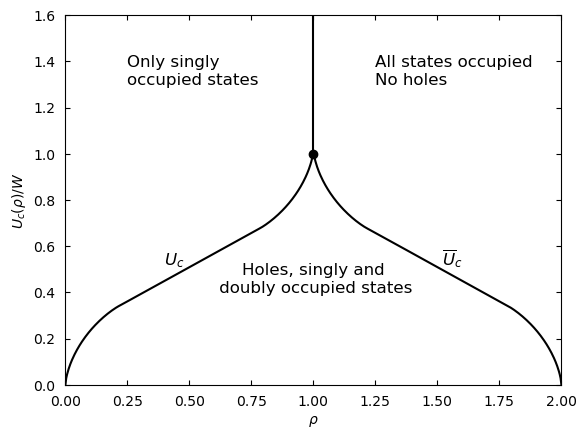

In [10]:
U_c_norm_copy = np.array(U_c_array_copy) / np.max(U_c_array_copy)
phase_diagram(rho_values, U_c_norm_copy, r'$\rho$', r'$U_c(\rho) / W$', 1.6, fill=False)